In [ ]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
#from matplotlib.colors import to_rgba
#import seaborn as sns
#sns.set()

## Progress bar
#from tqdm.notebook import tqdm


# Import pytorch libraries
import torch
import torch.nn as nn # neural network module
import torch.nn.functional as F # functional module
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.utils.data as data # loads datasets

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset

In [2]:
# make dataset
# Set parameters
n_samples = 50

# make moons
from sklearn.datasets import make_moons
data_samples, label = make_moons(n_samples, noise=0.1, random_state=42) 


# # visualize the dataset
# plt.scatter(data_samples[:,0], data_samples[:,1], c=label)
# plt.show()

# create a dataset with the above data
moon_data = np.array(data_samples, dtype=np.float32)
moon_labels = np.array(label, dtype=np.float32)

In [3]:
# create nn layers model
class hidden_VFM(nn.Module): # hidden layer
    def __init__(self, hidden_dimension):
        super().__init__()
        self.linear1 = nn.Linear(hidden_dimension, hidden_dimension)
        self.act = nn.SELU()

    def forward(self, x):
        #return self.act(self.linear1(x))  
        return x + self.act(self.linear1(x))  # residual connection 

class CFG_VFM_Model(nn.Module):
    def __init__(self, data_dimension, num_hidden, hidden_dimension, time_dimension, classes): 
        super().__init__()

        self.time_dimension = time_dimension #embed time to vector
        self.label_embedding = nn.Embedding(classes + 1, hidden_dimension) # embed class labels and null label to vector

        self.input_dimension = data_dimension
        self.hidden_dimension = hidden_dimension

        # project data and time into hidden dimension
        self.in_projection = nn.Linear(data_dimension + time_dimension + hidden_dimension, hidden_dimension) # TODO also remove class label here?
        # hidden layers (does not contain in/out projections)
        self.hidden_layers = nn.Sequential(
            #nn.SELU(),
            *[hidden_VFM(hidden_dimension) for _ in range(num_hidden)], # list of hidden layers
        )
        # output projection
        self.out_projection = nn.Linear(hidden_dimension, data_dimension)

    # sinusoidal time embedding function, allows the model to understand at which time it is (see Transformers)
    def time_embed(self, t):
        # t: shape (batch,) or (batch,1)
        #t = t * 1000
        half_dim = self.time_dimension // 2
        # use torch/math for consistency and correct device handling
        emb_scale = -math.log(10000.0) / (half_dim - 1)
        freqs = torch.exp(torch.arange(half_dim, device=t.device, dtype=torch.float32) * emb_scale)
        t = t.to(dtype=torch.float32)
        emb = t[:, None] * freqs[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

    def forward(self, x, t, y):
        t = self.time_embed(t)
        y = self.label_embedding(y)
        x_input = torch.cat([x, t, y], dim=-1) # concatenate input, time embedding, and label embedding
        x = self.in_projection(x_input) # project input to hidden dimension

        x = self.hidden_layers(x) # pass through hidden layers        
        mu_pred = self.out_projection(x) # predicted mean of x_1

        return mu_pred

In [4]:
n_samples = 1000
data_samples, label = make_moons(n_samples, noise=0.1, random_state=42) 
num_hidden = 8
hidden_dimension = 256

# normalize data
data_mean = data_samples.mean(axis=0)
data_std = data_samples.std(axis=0)
normalized_data = (data_samples - data_mean) / data_std

training_data = torch.tensor(normalized_data, dtype=torch.float32).to(device)
training_labels = torch.tensor(label, dtype=torch.float32).to(device)
training_labels = training_labels.long()  # Convert labels to long type for embedding

VFM_model_1 = CFG_VFM_Model(data_dimension=2, num_hidden=num_hidden, hidden_dimension=hidden_dimension, time_dimension=16, classes=2).to(device)
optim = torch.optim.AdamW(VFM_model_1.parameters(), lr=1e-4) 

In [5]:
# Training
def train_model(model, training_data, classes, training_steps, batch_size, optim, scheduler):
    null_label = 2  # Define null label index ¨2¨
    dropout = 0.1 # Probability of dropping the label
    losses = []
    
    pbar = tqdm(range(training_steps))
    for step in pbar:
        optim.zero_grad()

        # Sample a batch of data x_1
        indices = torch.randint(0, len(training_data), (batch_size,), device=training_data.device) 
        x_1 = training_data[indices]
        y = classes[indices].long()  # get corresponding labels and convert to long for embedding

        # Apply label dropout
        mask = torch.rand(y.size(), device=y.device) < dropout # create mask
        y = torch.where(mask, torch.full_like(y, null_label), y) # replace dropped labels with null label

        # Sample noise data x_0
        x_0 = torch.randn_like(x_1)

        # Sample random time between 0 and 1 on the correct device
        t = torch.rand(x_1.size(0), device=x_1.device)

        # Interpolate between x_0 and x_1
        x_t = (t[:, None] * x_1) + (1 - t[:, None]) * x_0 

        # Predict the velocity using the model
        mu_pred = model(x_t, t, y) 

        # Compute the loss (assuming the variational distribution is a multivariate gaussian and the data is continuous)
        loss = torch.mean((mu_pred - x_1)**2) # compares nn output to the true data point --> nn becomes a true data destination predictor (will thereby try to predict the mean of true data points)

        # Backpropagation and optimization step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.02)
        optim.step()
        scheduler.step()

        # Update progress bar
        current_lr = scheduler.get_last_lr()[0]
        pbar.set_postfix(loss=loss.item(), lr=f"{current_lr:.2e}")
        losses.append(loss.item())

    return losses

In [6]:
# train the model
#training_data = torch.tensor(moon_data)
training_steps = 40000
batch_size = 256
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max = training_steps, eta_min=1e-6)
#losses = [] #TODO replace based on loss function (corss entropy etc)
classes = training_labels

losses = train_model(VFM_model_1, training_data, classes, training_steps, batch_size, optim, scheduler)

100%|██████████| 40000/40000 [08:23<00:00, 79.37it/s, loss=0.305, lr=1.00e-06] 


/tmp/ipykernel_505523/1217350295.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 0.6)


Text(0.5, 1.0, 'Training Loss over Time')

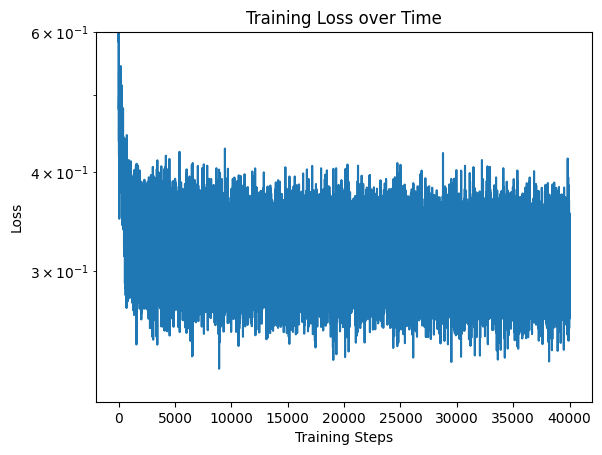

In [28]:
#plot loss in log scale
#from matplotlib import pyplot

plt.plot(losses)
plt.yscale('log')
plt.ylim(0, 0.6)
#plt.plot(losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Time")

In [29]:
# pyplot.plot(losses)
# pyplot.yscale('log')
# pyplot.ylim(0.3, 0.6)
# pyplot.xlim(39900, 40000)
# #plt.plot(losses)
# plt.xlabel("Training Steps")
# plt.ylabel("Loss")
# plt.title("Training Loss over Time")

In [30]:
# Generation

def generate_model(model, y, test_size, num_steps, scale):
    model.eval() # set model to evaluation mode
    null = 2  # Define null label index ¨2¨

    with torch.no_grad(): # disable gradient calculation for evaluation
        # start with pure noise
        x_current = torch.randn(test_size, 2) # for the batch size, generate random noises (feature 1, feature 2)
        dt = 1 / num_steps # step sizes going from x_0 to x_1

        y_cond = torch.full((test_size,), y, dtype=torch.long, device=x_current.device)  # create a tensor of size (test_size,) filled with the class label y
        y_uncond = torch.full((test_size,), null, dtype=torch.long, device=x_current.device)  # create a tensor of size (test_size,) filled with the null label

        # integrate from t=0 to t=1
        for i in range(num_steps):
            # at current time
            t_scalar = i / num_steps
            t_current = torch.ones(test_size) * t_scalar

            mu_t_cond = model(x_current, t_current, y_cond) # predict target end point (conditioned)
            mu_t_uncond = model(x_current, t_current, y_uncond) # predict target end point
            mu_t = mu_t_uncond + scale * (mu_t_cond - mu_t_uncond)  # CFG adjustment with guidance scale

            # compute velocity towards target
            # denominator = torch.clamp(1-t_current[:, None], min=0.05, max =1)
            # v_t = (mu_t - x_current) / denominator
            if (1-t_scalar) < 0.05: # for stability
                v_t = (mu_t - x_current) / (0.05)
            else:
                v_t = (mu_t - x_current) / (1 - t_current[:, None]) 

            # update next step
            x_next = x_current + v_t * dt

            x_current = x_next 

    return x_next

In [60]:
#test_samples, test_labels = make_moons(500, noise=0.1, random_state=24) 
#test_data = torch.tensor(test_samples, dtype=torch.float32).to(device)
#test_labels = torch.tensor(test_labels, dtype=torch.float32).to(device)
test_size = 1000
num_steps = 100
scale = 1.5
y = 0  # generate samples of a specific class


generated_data = generate_model(VFM_model_1, y, test_size, num_steps, scale).numpy()

# unnormalize generated data
unnormalized_generated_data = generated_data * data_std + data_mean

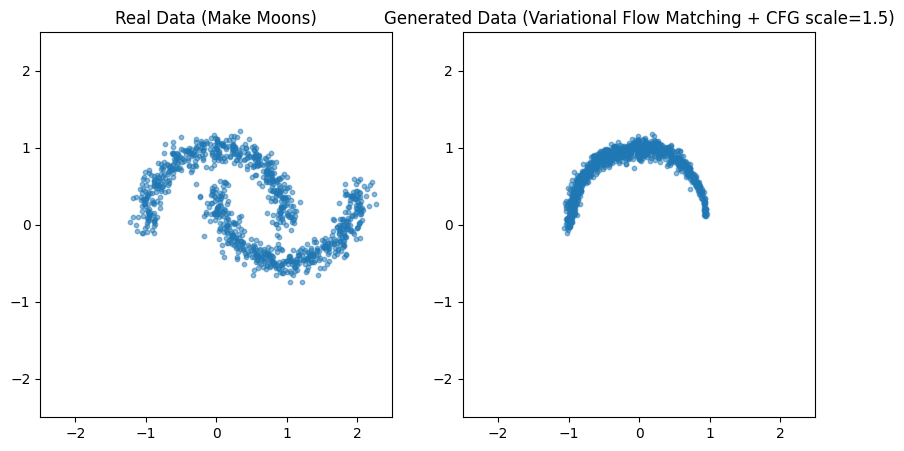

In [61]:
# Visual Comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_samples[:, 0], data_samples[:, 1], alpha=0.5, s=10)
plt.title("Real Data (Make Moons)")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

plt.subplot(1, 2, 2)
plt.scatter(unnormalized_generated_data[:, 0], unnormalized_generated_data[:, 1], alpha=0.5, s=10)
plt.title("Generated Data (Variational Flow Matching + CFG scale={})".format(scale))
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
#plt.savefig("Simple_VFM_01162025_2_numhidden8_hiddendim256_strainingsteps40000_batchsizes256_1-t0.02.png")
plt.show()

In [ ]:
# Quick smoke test for FM_model_1
# This cell checks a forward pass and that shapes / devices are consistent
x_t = torch.randn(4, 2).to(device)
t = torch.rand(4, device=device)
v_pred = FM_model_1(x_t, t)
print("v_pred.shape:", v_pred.shape)
print("v_pred device:", v_pred.device)
print("Sample values:\n", v_pred[:2])

v_pred.shape: torch.Size([4, 2])
v_pred device: cpu
Sample values:
 tensor([[-0.5950,  0.1626],
        [ 0.3058, -0.4946]], grad_fn=<SliceBackward0>)
